In [181]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
import time
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo


#This cell is now outdated with the newer catalogue releases

#Read in the LOFAR data both optical and radio
lofar_rad = Table.read('data/radio/EN1_ML_RUN_fin_overlap_srl_workflow.fits')
lofar_opt = Table.read('data/optical/EN1_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
lofar_opt.rename_column('ALPHA_J2000','ra')
lofar_opt.rename_column('DELTA_J2000','dec')

#merge the optical and radio catalogue to find out which optical sources need crossmatching to HELP
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [182]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]
                                    

In [183]:
len(lofar)

8370

In [184]:
taskid = 1000
batch_size = 1

if taskid*batch_size>len(lofar):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)-1
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids = lofar['Source_Name'][ind_low:ind_up]

In [55]:
source_use = [0,1,2,3,4,5,6,7,8,9]
ras = lofar['optRA'][source_use]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][source_use][mask]

decs = lofar['optDec'][source_use]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][source_use][mask]

ids = lofar['Source_Name'][source_use]

In [185]:
len(ras)

1

In [6]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/ELAIS-N1/data/'

pswfits=imfolder+'wp4_elais-n1_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[2].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
#pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

MIPS_psf=fits.open(imfolder+'dmu17_MIPS_PSF_ELAIS-N1_20170629.fits')

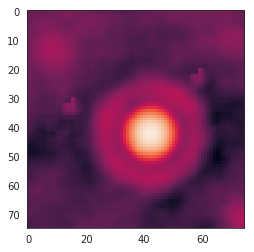

In [82]:
plt.imshow(np.log10(MIPS_psf[1].data[125:200,125:200]))
plt.show()

In [135]:
#find the flux at the position of each source
ras = prior250.sra
decs = prior250.sdec

pixx,pixy = w_250.wcs_world2pix(ras,decs,0,ra_dec_order=True)
fluxs = im250[pixx.astype(int),pixy.astype(int)]

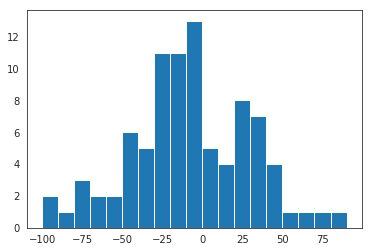

In [163]:
plt.hist(fluxs,bins=np.arange(-100,100,10))
plt.show()

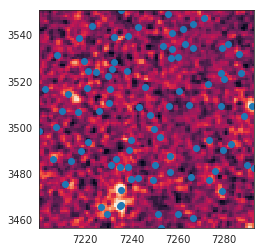

In [143]:
plt.imshow(im250,vmin=np.percentile(im250,1),vmax=np.percentile(im250,99))
plt.scatter(pixx,pixy)
plt.xlim(min(pixx),max(pixx))
plt.ylim(min(pixy),max(pixy))

plt.show()

# find the position of the radio source
ra = lofar['ra'][[3]]
dec = lofar['dec'][[3]]

#using pyvo find all help objects within 1 arcminute of the rdaio crossmatch
columns = 'ra','dec','help_id','f_spire_250','ferr_spire_250','flag_spire_250','f_spire_350','ferr_spire_350','flag_spire_350','f_spire_500','ferr_spire_500','flag_spire_500','flag_optnir_det','f_mips_24'
query = """
SELECT *
FROM herschelhelp.main AS db
JOIN TAP_UPLOAD.t1 AS tc
ON 1=CONTAINS(POINT('ICRS', db.ra, db.dec),
CIRCLE('ICRS', tc.RA, tc.DEC, 1./60.))
"""

pos = Table()
pos.add_column(Column(data=ra, name='ra'))
pos.add_column(Column(data=dec, name='dec'))

service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")
job = service.submit_job(query,
                          uploads = {'t1': pos})
job.run()
    
while job.phase == "EXECUTING":
    print("Job running")
    sleep(5)
print('job finsihed')
help_all = job.fetch_result().to_table()
help_all['help_id'] = help_all['help_id'].astype(str)
help_all.remove_column('ra_')
help_all.remove_column('dec_')

In [43]:
#Read in the HELP masterlist and select the wanted columns
columns = 'ra','dec','help_id','flag_optnir_det','f_mips_24',
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist = masterlist[columns]

#### following cells are for the python version of the code as pyvo doesn't seem to work on apollo2 when submitted to the queue

#comparing with the help masterlist from fits file
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist = help_masterlist[columns]

lofar_coords = SkyCoord(ra,dec,unit='deg')
help_coords = SkyCoord(help_masterlist['ra'],help_masterlist['dec'],unit='deg')
radius = 60
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)
help_masterlist = help_masterlist[idx_help]

#Read in the Ldust prdictions from CIGALE
#when these are on the VO i will change code to read it in from then
ldust = Table.read('../../../../../HELP/dmu_products/dmu28/dmu28_ELAIS-N1/data/ELAIS_N1_Ldust_prediction_results.fits') 
ldust.rename_column('id','help_id')
ldust['help_id'] = ldust['help_id'].astype(str)
#join Ldust predictions with the help table
help_masterlist_ldust = join(help_masterlist,ldust,keys='help_id',join_type='inner')

In [56]:
#create the prior list from the help masterlist
prior_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)
prior_cat = help_masterlist[prior_mask]
for n,pos in enumerate(ras):
    prior_cat.add_row([ras[n],decs[n],ids[n],-99,np.nan])

In [7]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat_MIPS.fits')
MIPS_lower = prior_cat['MIPS_lower']
MIPS_upper = prior_cat['MIPS_upper']

In [8]:
len(prior_cat)

439803

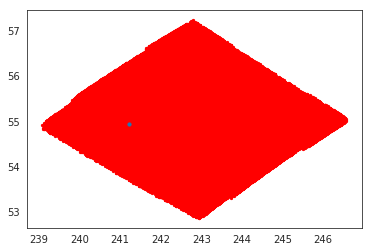

In [84]:
#x = help_masterlist['ra']
#y = help_masterlist['dec']
#plt.scatter(x,y,s=1)

x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=5,color='red')

x = ras
y = decs
plt.scatter(x,y,s=10)

#plt.xlim(np.min(help_masterlist['ra']),np.max(help_masterlist['ra']))
#plt.ylim(np.min(help_masterlist['dec']),np.max(help_masterlist['dec']))
plt.show()

#if there is only one crossmatch within the search radius then match them if the source is in the prior list
#otherwise add the ra and dec of the lofar optical counterpart to the prior list
XID_rerun = []
source_type = []
mask = (help_masterlist[idx_help]['flag_optnir_det']>=5) & (help_masterlist[idx_help]['f_mips_24']>20)
idx_true = idx_help[mask]

if len(d2d) == 0:
    min_d2d = np.nan
else:
    min_d2d = np.min(d2d)

if d2d[mask] != min_d2d:
    source_type.append('nearer_non_prior')
    XID_rerun.append(False)
if np.sum(mask)==0:
    prior_cat.add_row([ra,dec,'lofar',np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,-99,np.nan,False])
    source_type.append('radio_position')
    XID_rerun.append(True)
if np.sum(mask)>1:
    nearer = ''
    if np.min(d2d[mask]) != min_d2d:
        nearer = 'nearer_non_prior'
    for n in range(np.sum(mask)):
        source_type.append('multiple_prior'+nearer)
        XID_rerun.append(False)
if np.sum(mask)==1:
    source_type.append('nearest_prior')
    XID_rerun.append(False)
    if d2d[mask] != np.min(d2d):
        source_type.append('nearer_non_prior')
        XID_rerun.append(False)


if False in XID_rerun:
    mask = lofar['ra']==ra
    lofar_fir = hstack([lofar[mask],help_masterlist[idx_true]])
    XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
    source_type_col = Column(data=source_type,name='source_type',dtype=str)
    lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
    #os.mkdir('testfolder')
    #Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [248]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,15,15)

In [266]:
#---prior250--------
t1 = time.time()
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

#prior250=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=moc)
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',flux_lower=MIPS_lower,flux_upper=MIPS_upper,ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



time taken is: 549.84832239151s


In [267]:
#for 1 source with 15" radius moc it took ~540s
#for 10 sources with 15" radius moc it took ~620s
#for 50 sources with 15" radius moc it took ~570s

In [268]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=20
prior250.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,41/2.0,0.5),np.arange(0,41/2.0,0.5))#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)

In [269]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+' pixels')



fitting 6 sources 

using 465 pixels


In [270]:
prior250.get_pointing_matrix()

In [271]:
prior250.upper_lim_map()

In [272]:
from xidplus.stan_fit import MIPS,SPIRE
t1 = time.time()
fit=MIPS.MIPS_24(prior250,iter=2000)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

/lustre/scratch/astro/im281/FIR-group/Ian/lofar/deep_fields/ELAIS-N1/XID+MIPS.pkl
/XID+MIPS found. Reusing
time taken is: 2.8868408203125s


In [273]:
#50 sources took ~120s

In [274]:
posterior=xidplus.posterior_stan(fit,[prior250])

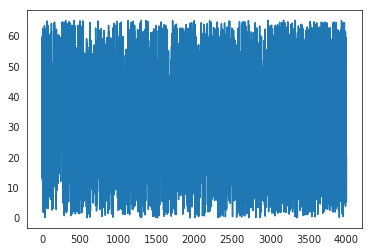

In [237]:
y = posterior.samples['src_f'][:,0,6]
plt.plot(np.arange(0,len(y)),y)

In [156]:
np.max(posterior.samples['src_f'])

320.93644271966235

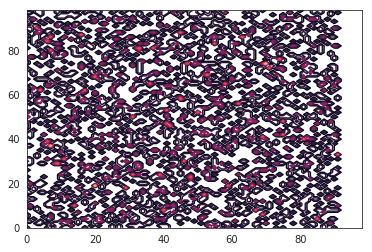

In [316]:
bins = np.arange(0,100,1)
data,_,_ = np.histogram2d(posterior.samples['src_f'][999:,0,3],posterior.samples['src_f'][999:,0,1],bins=bins)
#plt.imshow(data)
plt.contour(data)
plt.show()

In [275]:
priors = [prior250]

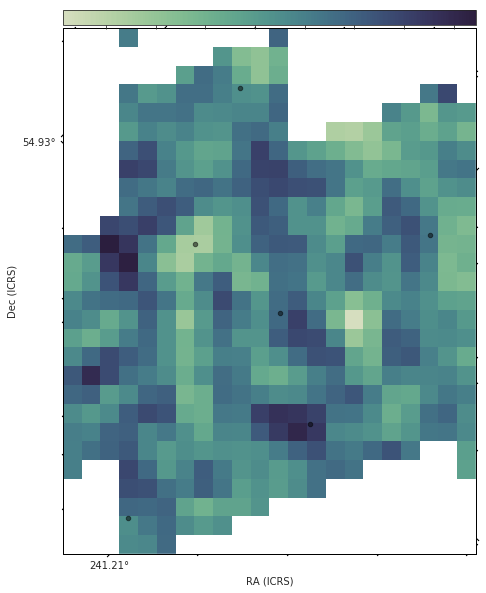

In [276]:
figs,fig=xidplus.plot_map(priors)

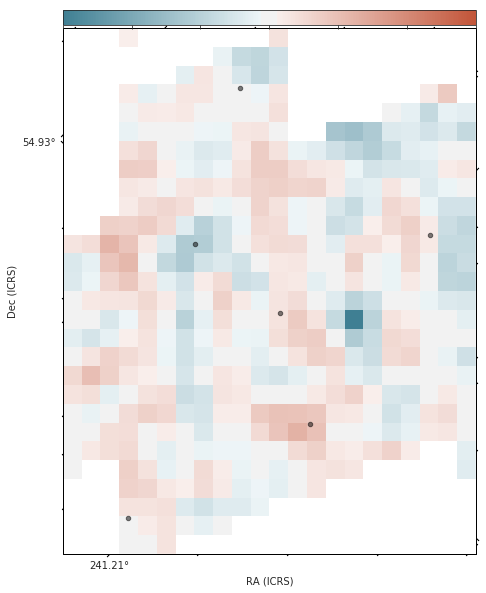

In [277]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [278]:
import xidplus.catalogue as cat
MIPS_cat=cat.create_MIPS_cat(posterior,priors[0],0)

In [279]:
MIPS_cat = Table.read(MIPS_cat)

In [280]:
help_XID = Table.read('data/fir_MIPS_v10/dmu26_XID+MIPS_ELAIS-N1_SERVS_cat_20170725.fits')
joined = join(MIPS_cat,help_XID,join_type='inner',keys='help_id')
len(joined)

5

In [281]:
joined[:5]

help_id,RA_1,Dec_1,F_MIPS_24_1,FErr_MIPS_24_u_1,FErr_MIPS_24_l_1,Bkg_MIPS_24_1,Sig_conf_MIPS_24_1,Rhat_MIPS_24_1,n_eff_MIPS_24_1,Pval_res_24_1,RA_2,Dec_2,F_MIPS_24_2,FErr_MIPS_24_u_2,FErr_MIPS_24_l_2,Bkg_MIPS_24_2,Sig_conf_MIPS_24_2,Rhat_MIPS_24_2,n_eff_MIPS_24_2,Pval_res_24_2,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,,,,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,bool
HELP_J160449.989+545545.943,241.208286902057,54.9294286024993,49.360302,82.606415,16.291082,-6.523287,4.9140804e-06,0.9996028,6582.0483,0.0,241.208286902057,54.9294286024993,62.915478,77.685974,48.87451,-0.012869859,5.3310478e-06,nan,2000.0,0.0,False
HELP_J160450.310+545559.974,241.20962438527454,54.9333260025667,45.25026,76.13683,14.5471945,-6.523287,4.9140804e-06,0.99914825,6951.2896,0.0,241.20962438527454,54.9333260025667,4.0103416,9.82464,0.9452985,-0.012869859,5.3310478e-06,nan,2000.0,0.0,True
HELP_J160450.483+545533.526,241.210345059057,54.9259795004993,45.941956,77.43577,14.174008,-6.523287,4.9140804e-06,0.99918705,6492.094,0.0,241.210345059057,54.9259795004993,64.22729,78.667595,49.651463,-0.012744445,5.015081e-06,nan,2000.0,0.0,False
HELP_J160451.529+545549.150,241.214705077057,54.9303195514993,50.60758,84.43568,15.927759,-6.523287,4.9140804e-06,0.999269,6666.2056,0.0,241.214705077057,54.9303195514993,6.5774846,14.267109,2.0413175,-0.012744445,5.015081e-06,nan,2000.0,0.0,True
HELP_J160452.086+545558.344,241.2170259928015,54.93287319600057,50.60345,84.434555,15.813201,-6.523287,4.9140804e-06,1.0000798,7580.9224,0.0,241.2170259928015,54.93287319600057,19.918062,33.660637,8.358748,-0.012869859,5.3310478e-06,nan,2000.0,0.0,True


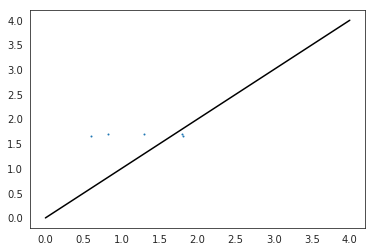

In [282]:
x = np.log10(joined['F_MIPS_24_2'])
xerr_u = np.log10(joined['FErr_MIPS_24_u_2']-joined['F_MIPS_24_2'])
yerr_l = np.log10(joined['F_MIPS_24_2']-joined['FErr_MIPS_24_l_2'])
y = np.log10(joined['F_MIPS_24_1'])
yerr_u = np.log10(joined['FErr_MIPS_24_u_1']-joined['F_MIPS_24_1'])
yerr_l = np.log10(joined['F_MIPS_24_1']-joined['FErr_MIPS_24_l_1'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([0,4],[0,4],c='black')
plt.show()

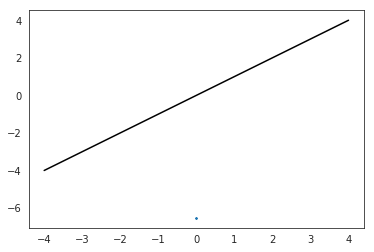

In [283]:
x = joined['Bkg_MIPS_24_2']
#xerr = np.log10(joined['ferr_mips_24'])
y = joined['Bkg_MIPS_24_1']


#plt.errorbar(x[::10],y[::10],xerr=xerr[::10],yerr=[yerr_u[::10],yerr_l[::10]],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([-4,4],[-4,4],c='black')
plt.show()

In [67]:
mask = [MIPS_cat['help_id'][i] in ids for i in range(len(MIPS_cat))]
MIPS_cat[mask]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ155958.68+550534.6,239.9942929896559,55.0930282279941,90.73344,145.95277,30.674541,2.737582,4.8642487e-06,0.9985452,3958.191,0.0


In [140]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [141]:
lofar_fir

Source_id,Isl_id,RA_1,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,FLAG_OVERLAP_1,lr_fin,lr_dist_fin,lr_index_fin,fworkflow_all,FLAG_WORKFLOW,NUMBER,SNR_WIN,BACKGROUND,THRESHOLD,X_IMAGE,Y_IMAGE,ra,dec,X2_IMAGE,Y2_IMAGE,XY_IMAGE,X2_WORLD,Y2_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,FLAGS_i,CLASS_STAR,FLAGS_J,FLAGS_K,FLAGS_g,FLAGS_hscg,FLAGS_hsci,FLAGS_hscnb921,FLAGS_hscr,FLAGS_hscy,FLAGS_hscz,FLAGS_r,FLAGS_se1,FLAGS_se2,FLAGS_sw1,FLAGS_sw2,FLAGS_sw3,FLAGS_sw4,FLAGS_u,FLAGS_y,FLAGS_z,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,MAG_APER_sw4_1,MAG_APER_sw4_2,MAG_APER_sw4_3,MAG_APER_sw4_4,MAG_APER_sw4_5,MAG_APER_sw4_6,MAG_APER_sw4_7,MAG_APER_sw4_10,MAGERR_APER_sw4_1,MAGERR_APER_sw4_2,MAGERR_APER_sw4_3,MAGERR_APER_sw4_4,MAGERR_APER_sw4_5,MAGERR_APER_sw4_6,MAGERR_APER_sw4_7,MAGERR_APER_sw4_10,FLUX_APER_sw4_1,FLUX_APER_sw4_2,FLUX_APER_sw4_3,FLUX_APER_sw4_4,FLUX_APER_sw4_5,FLUX_APER_sw4_6,FLUX_APER_sw4_7,FLUX_APER_sw4_10,FLUXERR_APER_sw4_1,FLUXERR_APER_sw4_2,FLUXERR_APER_sw4_3,FLUXERR_APER_sw4_4,FLUXERR_APER_sw4_5,FLUXERR_APER_sw4_6,FLUXERR_APER_sw4_7,FLUXERR_APER_sw4_10,MAG_APER_sw1_1,MAG_APER_sw1_2,MAG_APER_sw1_3,MAG_APER_sw1_4,MAG_APER_sw1_5,MAG_APER_sw1_6,MAG_APER_sw1_7,MAG_APER_sw1_10,MAGERR_APER_sw1_1,MAGERR_APER_sw1_2,MAGERR_APER_sw1_3,MAGERR_APER_sw1_4,MAGERR_APER_sw1_5,MAGERR_APER_sw1_6,MAGERR_APER_sw1_7,MAGERR_APER_sw1_10,FLUX_APER_sw1_1,FLUX_APER_sw1_2,FLUX_APER_sw1_3,FLUX_APER_sw1_4,FLUX_APER_sw1_5,FLUX_APER_sw1_6,FLUX_APER_sw1_7,FLUX_APER_sw1_10,FLUXERR_APER_sw1_1,FLUXERR_APER_sw1_2,FLUXERR_APER_sw1_3,FLUXERR_APER_sw1_4,FLUXERR_APER_sw1_5,FLUXERR_APER_sw1_6,FLUXERR_APER_sw1_7,FLUXERR_APER_sw1_10,MAG_APER_sw3_1,MAG_APER_sw3_2,MAG_APER_sw3_3,MAG_APER_sw3_4,MAG_APER_sw3_5,MAG_APER_sw3_6,MAG_APER_sw3_7,MAG_APER_sw3_10,MAGERR_APER_sw3_1,MAGERR_APER_sw3_2,MAGERR_APER_sw3_3,MAGERR_APER_sw3_4,MAGERR_APER_sw3_5,MAGERR_APER_sw3_6,MAGERR_APER_sw3_7,MAGERR_APER_sw3_10,FLUX_APER_sw3_1,FLUX_APER_sw3_2,FLUX_APER_sw3_3,FLUX_APER_sw3_4,FLUX_APER_sw3_5,FLUX_APER_sw3_6,FLUX_APER_sw3_7,FLUX_APER_sw3_10,FLUXERR_APER_sw3_1,FLUXERR_APER_sw3_2,FLUXERR_APER_sw3_3,FLUXERR_APER_sw3_4,FLUXERR_APER_sw3_5,FLUXERR_APER_sw3_6,FLUXERR_APER_sw3_7,FLUXERR_APER_sw3_10,MAG_APER_sw2_1,MAG_APER_sw2_2,MAG_APER_sw2_3,MAG_APER_sw2_4,MAG_APER_sw2_5,MAG_APER_sw2_6,MAG_APER_sw2_7,MAG_APER_sw2_10,MAGERR_APER_sw2_1,MAGERR_APER_sw2_2,MAGERR_APER_sw2_3,MAGERR_APER_sw2_4,MAGERR_APER_sw2_5,MAGERR_APER_sw2_6,MAGERR_APER_sw2_7,MAGERR_APER_sw2_10,FLUX_APER_sw2_1,FLUX_APER_sw2_2,FLUX_APER_sw2_3,FLUX_APER_sw2_4,FLUX_APER_sw2_5,FLUX_APER_sw2_6,FLUX_APER_sw2_7,FLUX_APER_sw2_10,FLUXERR_APER_sw2_1,FLUXERR_APER_sw2_2,FLUXERR_APER_sw2_3,FLUXERR_APER_sw2_4,FLUXERR_APER_sw2_5,FLUXERR_APER_sw2_6,FLUXERR_APER_sw2_7,FLUXERR_APER_sw2_10,MAG_APER_se2_1,MAG_APER_se2_2,MAG_APER_se2_3,MAG_APER_se2_4,MAG_APER_se2_5,MAG_APER_se2_6,MAG_APER_se2_7,MAG_APER_se2_10,MAGERR_APER_se2_1,MAGERR_APER_se2_2,MAGERR_APER_se2_3,MAGERR_APER_se2_4,MAGERR_APER_se2_5,MAGERR_APER_se2_6,MAGERR_APER_se2_7,MAGERR_APER_se2_10,FLUX_APER_se2_1,FLUX_APER_se2_2,FLUX_APER_se2_3,FLUX_APER_se2_4,FLUX_APER_se2_5,FLUX_APER_se2_6,FLUX_APER_se2_7,FLUX_APER_se2_10,FLUXERR_APER_se2_1,FLUXERR_APER_se2_2,FLUXERR_APER_se2_3,FLUXERR_APER_se2_4,FLUXERR_APER_se2_5,FLUXERR_APER_se2_6,FLUXERR_APER_se2_7,FLUXERR_APER_se2_10,MAG_APER_se1_1,MAG_APER_se1_2,MAG_APER_se1_3,MAG_APER_se1_4,MAG_APER_se1_5,MAG_APER_se1_6,MAG_APER_se1_7,MAG_APER_se1_10,MAGERR_APER_se1_1,MAGERR_APER_se1_2,MAGERR_APER_se1_3,MAGERR_APER_se1_4,MAGERR_APER_se1_5,MAGERR_APER_se1_6,MAGERR_APER_se1_7,MAGERR_APER_se1_10,FLUX_APER_se1_1,FLUX_APER_se1_2,FL

In [147]:
os.path.exists('data/fir_v2/xidplus_run_3')

True

In [9]:
len(lofar)

32833

In [284]:
Table.write(MIPS_cat,'data/fir_MIPS_v10/MIPS_rerun_test_15arcseconds_5_sources.fits')

xidplus.save([prior250],posterior,'data/fir_MIPS_v10/MIPS_rerun_test_15arcseconds_5_sources')

## Compare the results from the different runs and teh roiginal HELP run

In [310]:
run_15 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_15arcseconds_5_sources.fits')
run_30 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_30arcseconds_22_sources.fits')
run_60 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_60arcseconds_89_sources.fits')
run_60_bkg_0 = Table.read('data/fir_MIPS_v10/MIPS_rerun_test_60arcseconds_89_sources_bkg_0.fits')

In [287]:
run_15[0]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J160449.989+545545.943,241.208286902057,54.9294286024993,49.360302,82.606415,16.291082,-6.523287,4.9140804e-06,0.9996028,6582.0483,0.0


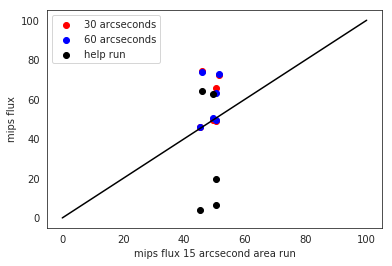

In [300]:
ids = run_15['help_id']
mask = np.array([name in ids for name in run_30['help_id']])
x = run_15['F_MIPS_24']
y = run_30['F_MIPS_24'][mask]
plt.scatter(x,y,c='red',label='30 arcseconds')

ids = run_15['help_id']
mask = np.array([name in ids for name in run_60['help_id']])
x = run_15['F_MIPS_24']
y = run_60['F_MIPS_24'][mask]
plt.scatter(x,y,c='blue',label='60 arcseconds')

tmp = join(run_15,help_XID,join_type='inner',keys='help_id')
x = tmp['F_MIPS_24_1']
y = tmp['F_MIPS_24_2']
plt.scatter(x,y,c='black',label='help run')

plt.plot([0,100],[0,100],c='black')
plt.xlabel('mips flux 15 arcsecond area run')
plt.ylabel('mips flux')
plt.legend()
plt.show()

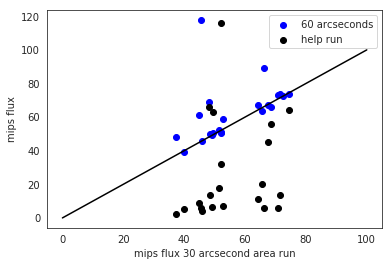

In [301]:
ids = run_30['help_id']
mask = np.array([name in ids for name in run_60['help_id']])
x = run_30['F_MIPS_24']
y = run_60['F_MIPS_24'][mask]
plt.scatter(x,y,c='blue',label='60 arcseconds')

tmp = join(run_30,help_XID,join_type='inner',keys='help_id')
x = tmp['F_MIPS_24_1']
y = tmp['F_MIPS_24_2']
plt.scatter(x,y,c='black',label='help run')

plt.plot([0,100],[0,100],c='black')
plt.xlabel('mips flux 30 arcsecond area run')
plt.ylabel('mips flux')
plt.legend()
plt.show()

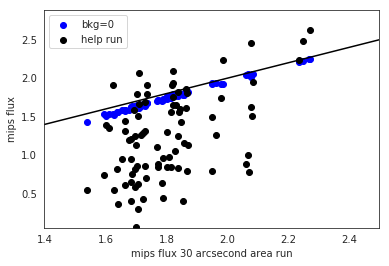

In [311]:
x = np.log10(run_60['F_MIPS_24'])
y = np.log10(run_60_bkg_0['F_MIPS_24'])
plt.scatter(x,y,c='blue',label='bkg=0')

tmp = join(run_60,help_XID,join_type='inner',keys='help_id')
x = np.log10(tmp['F_MIPS_24_1'])
y = np.log10(tmp['F_MIPS_24_2'])
plt.scatter(x,y,c='black',label='help run')

plt.plot([0,3],[0,3],c='black')

plt.xlim(np.min(x)/1.1,np.max(x)*1.1)
plt.ylim(np.min(y)/1.1,np.max(y)*1.1)
plt.xlabel('mips flux 30 arcsecond area run')
plt.ylabel('mips flux')
plt.legend()
plt.show()